# 条件生成对抗网络CGAN

CGAN是最早使目标数据生成成为可能的GAN创新之一，可以说是最具影响力的一种。接下来，介绍CGAN的工作方式以及如何用MNIST数据集实现它的小规模版本。

## CGAN原理
生成器学习为训练数据集中的每个标签生成逼真的样本，而鉴别器则学习区分真的样本-标签对与假的样本-标签对。半监督GAN的鉴别器除了区分真实样本与伪样本，还为每个真实样本分配正确的标签；而CGAN中的鉴别器不会学习识别哪个样本是哪个类。它只学习接受真实的且样本-标签匹配正确的对，拒绝不匹配的对和样本为假的对。

例如：无论样本1是真是假，CGAN的判别器都拒绝该（样本1与标签2）对，为了欺骗鉴别器，CGAN生成器仅生成逼真的数据是不够的，生成的样本还需要与标签相匹配。在对生成器进行充分训练之后，就可以通过传递所需的标签来指定希望CGAN合成的样本。

## CGAN的生成器

利用噪声z和标签y合成一个为样本x*|y
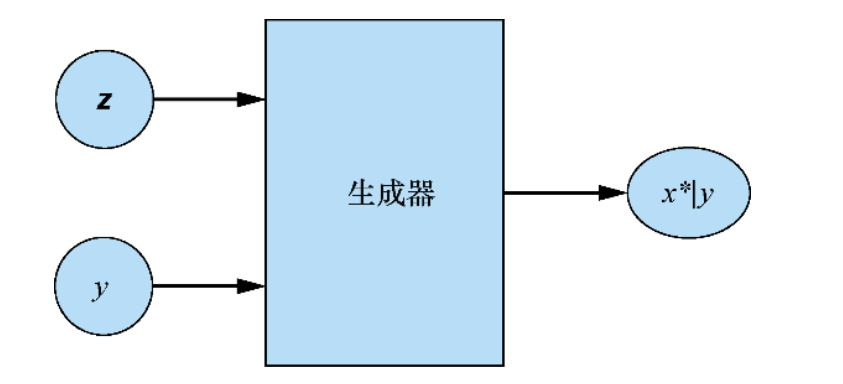

## CGAN的判别器

接受带标签的真实样本(x,y)，以及带有标签的伪样本(x*|y,y)，在真实样本-标签对上，鉴别器学习如何识别真实数据以及如何识别匹配对。在生成器生成的样本中，鉴别器学习识别伪样本-标签对，以将它们与真实样本-标签对区分开来。
判别器输出表明输入是真实的匹配对的概率，它的目标是学会接受所有的真实样本-标签对，并拒绝所有伪样本和所有与标签不匹配的样本。
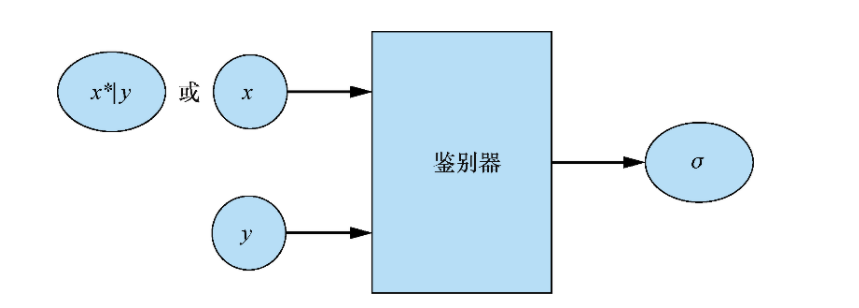

## 架构图与汇总表

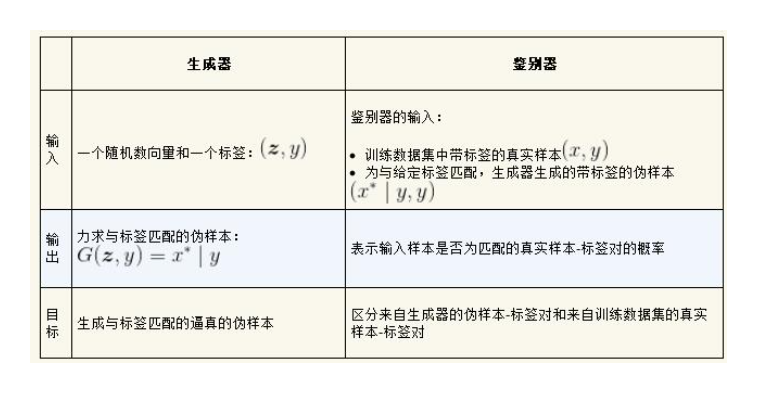

对于每个伪样本，相同的标签y同时被传递给生成器和鉴别器。另外，通过在带有不匹配标签的真实样本上训练鉴别器来拒绝不匹配的对；它识别不匹配对的能力是被训练成只接收真实匹配对时的副产品。
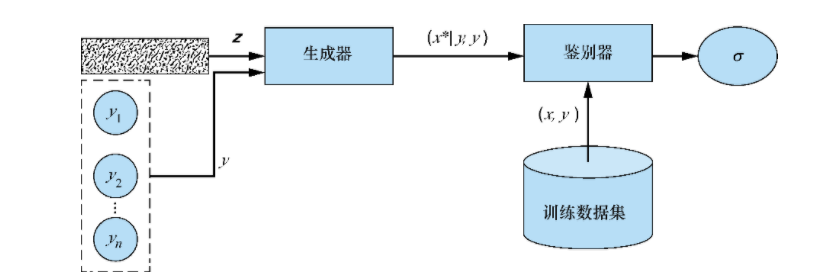

## CGAN的实现

In [1]:
# 导入包
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.datasets import mnist
from keras.layers import Embedding, Multiply, Dropout, Lambda, Concatenate, Input, Dense, Flatten, Reshape, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# 模型输入维度
img_rows = 28
img_cols = 28
channels = 1
# 图像大小
img_shape = (img_rows, img_cols, channels)
# 噪声向量大小
z_dim = 100

num_classes = 10

## 构造生成器

（1）使用Keras的Embedding层将标签y（0到9的整数）转换为大小为z_dim（随机噪声向量的长度）的稠密向量。

（2）使用Keras的Multiply层将标签与噪声向量z嵌入联合表示中。顾名思义，该层将两个等长向量的对应项相乘，并输出作为结果乘积的单个向量。

（3）将得到的向量作为输入，保留CGAN生成器网络的其余部分以合成图像。

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

def build_cgan_genertator(z_dim):
    z = Input(shape=(z_dim, ))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    
    joined_representation = Multiply()([z, label_embedding])
    
    generator = build_generator(z_dim)
    conditioned_img = generator(joined_representation)
    return Model([z, label], conditioned_img)

## 构造CGAN的判别器

步骤：

（1）取一个标签（0到9的整数），使用Keras的Embedding层将标签变成大小为28 × 28 × 1 = 784（扁平化图像的长度）的稠密向量。

（2）将嵌入标签调整为图像尺寸（28 × 28 × 1）。

（3）将重塑后的嵌入标签连接到对应图像上，生成形状（28 × 28× 2）的联合表示。可以将其视为在顶部“贴有”嵌入标签的图像。

（4）将图像-标签的联合表示输入CGAN的鉴别器网络中。注意，为了训练正常进行，必须将模型输入尺寸调整为（28 × 28 × 2）来对应新的输入形状。

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2]+1),padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def build_cgan_discriminator(img_shape):
    img = Input(shape=img_shape)
    
    label = Input(shape=(1, ), dtype='int32')
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding) # 将标签调整和输入图像一样的维度
    concatenated = Concatenate(axis= -1)([img, label_embedding])# 将图像与其嵌入标签链接
    discriminator = build_discriminator(img_shape)
    classification = discriminator(concatenated)
    return Model([img, label], classification)

## 搭建整个模型

In [6]:
def build_cgan(generator, discriminator):
    z = Input(shape=(z_dim, ))
    label = Input(shape=(1, ))
    img = generator([z, label])
    classification = discriminator([img, label])
    model = Model([z, label], classification)
    return model

discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator = build_cgan_genertator(z_dim)
discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 训练

In [7]:
losses = []
accuracies = []


def train(iterations, batch_size, sample_interval):
    (X_train, y_train), (_, _) = mnist.load_data('./MNIST')
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
#         print(X_train.shape[0])
        imgs, labels = X_train[idx], y_train[idx]
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])
#         print(imgs.shape)
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        g_loss = cgan.train_on_batch([z, labels], real)
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss[0], g_loss))
            accuracies.append(100.0 * d_loss[1])
            print("%d [D loss: %f, acc.: %.2f%%] [G loss:%f]"%(iteration + 1, d_loss[0], 100.0 * d_loss[1], g_loss))
            sample_images()

In [8]:
def sample_images (image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(10,4),sharey=True,sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title("Digit: %d" % labels[cnt])
            cnt +=1

Instructions for updating:
Use tf.cast instead.


D:\StudyApp\Anaconda\envs\learn\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.000204, acc.: 100.00%] [G loss:9.885448]
2000 [D loss: 0.000059, acc.: 100.00%] [G loss:9.908726]
3000 [D loss: 0.230777, acc.: 90.62%] [G loss:4.183795]
4000 [D loss: 0.040735, acc.: 98.44%] [G loss:3.380749]
5000 [D loss: 0.192189, acc.: 90.62%] [G loss:3.410103]
6000 [D loss: 0.134279, acc.: 98.44%] [G loss:3.005539]
7000 [D loss: 0.412724, acc.: 82.81%] [G loss:1.312850]
8000 [D loss: 0.211682, acc.: 90.62%] [G loss:3.666016]
9000 [D loss: 0.080928, acc.: 98.44%] [G loss:7.182220]
10000 [D loss: 0.107635, acc.: 98.44%] [G loss:2.332113]
11000 [D loss: 0.194184, acc.: 93.75%] [G loss:3.737709]
12000 [D loss: 0.191671, acc.: 89.06%] [G loss:4.127837]


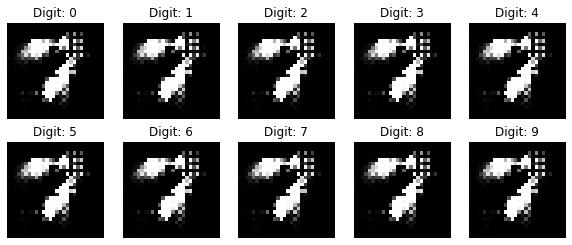

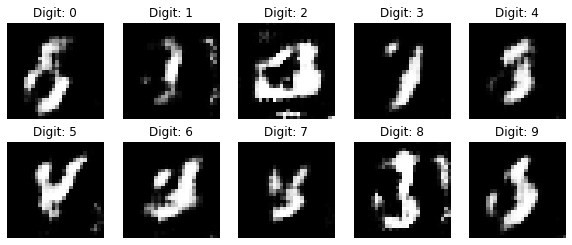

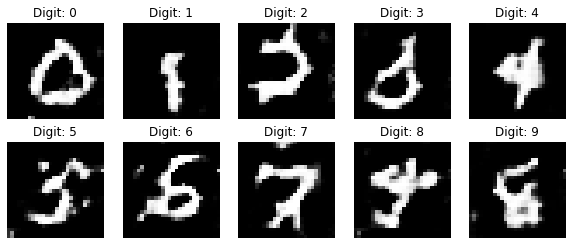

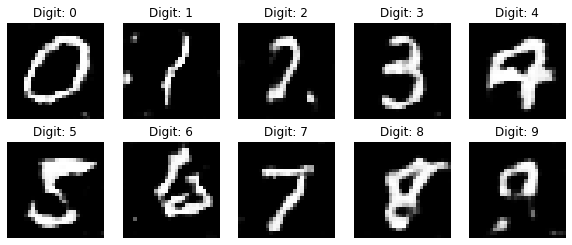

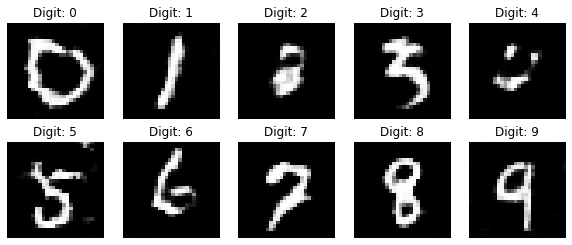

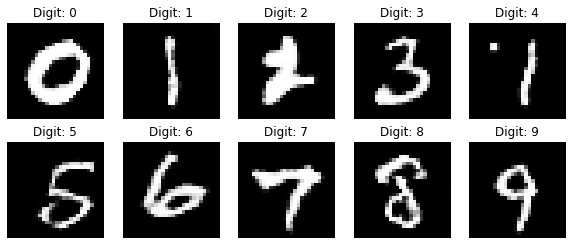

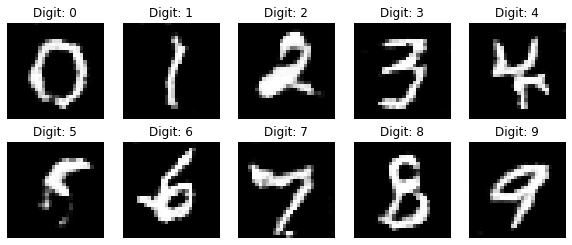

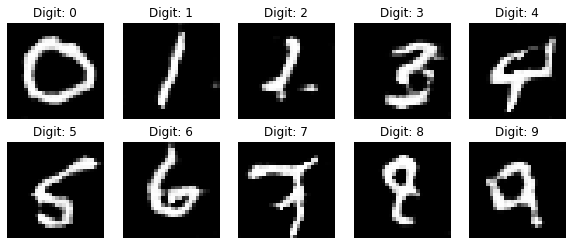

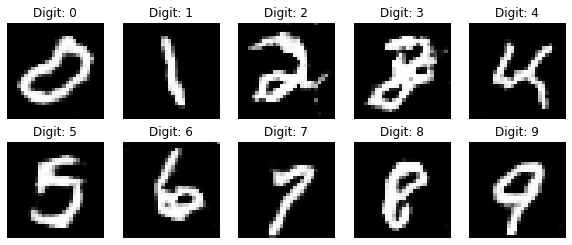

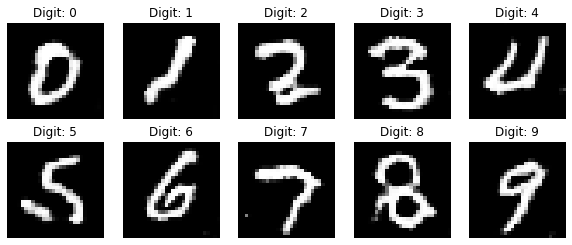

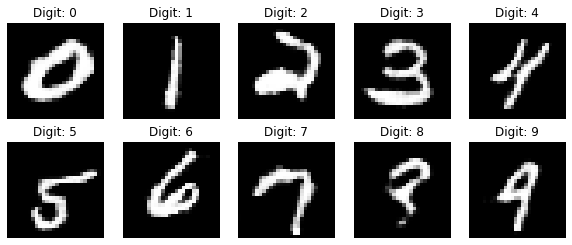

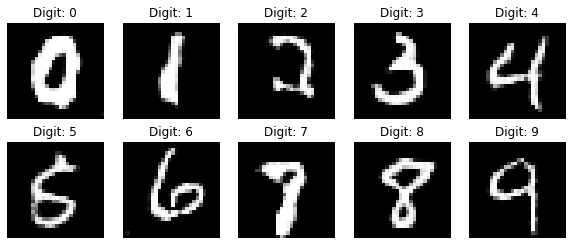

In [9]:
iterations  = 12000
batch_size = 32
sample_interval = 1000
train(iterations, batch_size, sample_interval)